### Distribution function for the DM mini-halo

The idea is the construct an equilibrium distribution function for a DM mini-halo (around a PBH) with a density profile $\rho \sim r^{-3/2}$ within the truncation radius $r_\mathrm{tr}$. 

In [23]:
import numpy as np
import sympy as sp

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

from matplotlib import pylab as pl
import matplotlib
matplotlib.rc('font', **{'size':16})

**Parameters:**

In [24]:
MPBH = 30.0
rtr = 0.0063*(MPBH**(1.0/3.0))
G = 4.302e-3 #Units of (pc/solar mass) (km/s)^2
A = 3.0*MPBH/(8*np.pi*rtr**3)
B = G*MPBH/rtr

**DM Density profile:**

In [25]:
#First transition at
x_a = 0.75
#Second transition at
x_b = 1.15

def rho_inner(x):
    return A*x**(-3.0/2.0)

#Constants chosen to give nice/fast 'turnover' properties for the density profile
#gamma = -1.982e7
gamma = -0.11e0
beta = -(3.0/2.0)*(x_a**-2.5) - 2*gamma*x_a #continuity of rho' at x = 1
alpha = rho_inner(x_a)/A - beta*x_a - gamma*x_a**2 #continuity of rho at x = 1

def rho_int(x):
    return A*(alpha + beta*x + gamma*x**2)

#Matching at x = 1.1
alpha1 = rho_int(x_b)/A
beta1 = -alpha1/(beta + 2*gamma*x_b)

def rho_outer(x):
    return A*alpha1*sp.exp(-(x-x_b)/beta1)

def rho_scalar(x):
    if (x < 0):
        return 0
    if (x <= x_a):
        return rho_inner(x)
    elif (x_a < x <= x_b):
        return rho_int(x)
    elif (x > x_b):
        return rho_outer(x)

rho = np.vectorize(rho_scalar)
    

**Plot the density...**

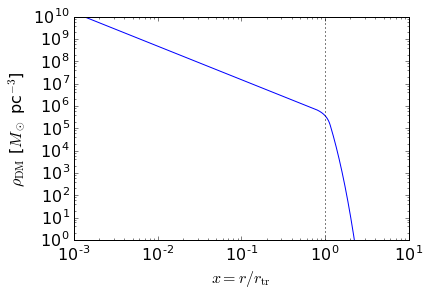

In [26]:
#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(3),1000)
pl.loglog(xlist, rho(xlist))
#pl.loglog(xlist, rho_inner(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.ylim(1, 1e10)
#pl.xlim(0.5, 2)
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
pl.savefig("../../Halo_density.pdf")
pl.show()

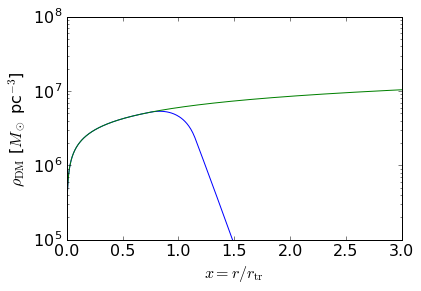

In [27]:
#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(3),1000)
pl.semilogy(xlist, 4*np.pi*rho(xlist)*xlist**2)
pl.semilogy(xlist, 4*np.pi*rho_inner(xlist)*xlist**2)
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.ylim(1e5, 1e8)
pl.show()

**Calculate masses and potentials:**

In [28]:
#Mass enclosed
def M_inner(x):
    return MPBH*(1+x**(3.0/2.0))

#x1 = sp.symbols('x1')
#def M_outer(x)
#    return 2*MPBH + rtr**3*4*np.pi*sp.integrate(rho(x1)*x1**2, (x1, 1, x))

x1,x2,y = sp.symbols('x1 x2 y')
M_int = M_inner(x_a) + rtr**3*4*np.pi*sp.integrate(rho_int(x1)*x1**2, (x1, x_a, x2))
M_outer = M_int.subs(x2,x_b) + rtr**3*4*np.pi*sp.integrate(rho_outer(x1)*x1**2, (x1, x_b, x2))


def Menc(x):
    if (x < x_a):
        return M_inner(x)
    elif (x_a <= x <= x_b):
        return M_int.subs(x2,x)
    elif (x > x_b):
        return M_outer.subs(x2,x)

psi_outer = (G/rtr)*sp.integrate(M_outer/x2**2, (x2, y, np.inf))
psi_int = (G/rtr)*sp.integrate(M_int/x2**2, (x2, y, x_b)) + psi_outer.subs(y, x_b)
psi_inner = (G/rtr)*sp.integrate(M_inner(x2)/x2**2, (x2, y, x_a)) + psi_int.subs(y, x_a)

print psi_outer

#Potential at transition points
psi_a = float(psi_int.subs(y,x_a))
psi_b = float(psi_outer.subs(y,x_b))

#def psi_inner(x):
#    return psi_a + B*(1 + x**-1 - 2.0*x**0.5)

def psi_scalar(x):
    if (x < x_a):
        return psi_inner.subs(y,x)
    elif (x_a <= x <= x_b):
        return psi_int.subs(y,x)
    elif (x > x_b):
        return psi_outer.subs(y,x)
    
psi = np.vectorize(psi_scalar)

psi_min = float(psi(1.5))
psi_max = float(psi(1e-4))


-0.219763774210234*(30834.6641820462*y + 5652.89219141834)*exp(-10.9093409666847*y)/y + 14.2954006323586/y


**Plot the potential and mass enclosed:**

Potential at x = 1.5: 9.52967242207
Potential at x = 1.1: 12.4028134279
Potential at x = 1: 18.1116389427
Potential at x = 1e-4: 65949.7407535
 
Mass enclosed at x = 1: 29.1605321613819
Mass enclosed at x = 1.5: 34.9820783756317
Mass enclosed at x = 2: 35.0489402969499
 
Fraction of particles inside x = 1: 0.832006393001920


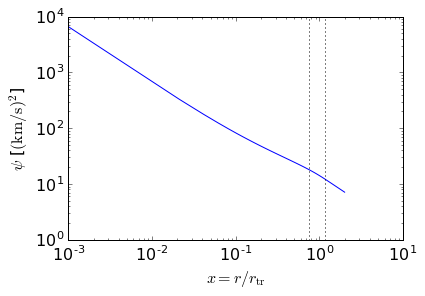

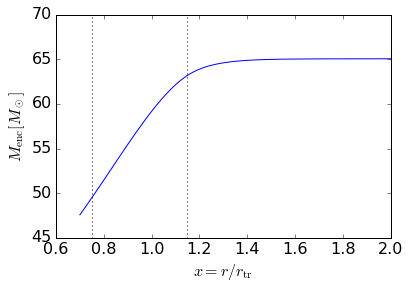

In [84]:
#Check the potential
print "Potential at x = 1.5:", psi_min
print "Potential at x = 1.1:", psi_b
print "Potential at x = 1:", psi_a
print "Potential at x = 1e-4:", psi_max
print " "
print "Mass enclosed at x = 1:", Menc(1.0)-30
print "Mass enclosed at x = 1.5:", Menc(1.5)-30
print "Mass enclosed at x = 2:", Menc(3)-30
print " "
print "Fraction of particles inside x = 1:", (Menc(1)-30)/(Menc(2)-30)

pl.figure()
xlist = np.linspace(1e-3, 2, 100)
pl.loglog(xlist, psi(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\psi$ [$(\mathrm{km}/\mathrm{s})^2$]")
pl.axvline(x_a, linestyle=':', color='k')
pl.axvline(x_b, linestyle=':', color='k')
pl.show()

pl.figure()
xlist = np.linspace(0.7, 2, 100)
pl.plot(xlist, np.vectorize(Menc)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$M_\mathrm{enc} [M_\odot]$")
pl.axvline(x_a, linestyle=':', color='k')
pl.axvline(x_b, linestyle=':', color='k')
pl.show()

**Calculating density as a function of potential:**

In [30]:
#List of x values
xlist = np.logspace(-4, np.log10(x_a-0.06),1000)
xlist = np.append(xlist,np.linspace(x_a-0.05, x_b+0.05),1000)
xlist = np.append(xlist,np.linspace(x_b+0.06,20,1000))
xlist = np.sort(xlist)

In [31]:
rholist = rho(xlist)
psilist = np.asarray(psi(xlist),dtype='float64')
rholist = np.append(rholist, 0)
psilist = np.append(psilist, 0)
rho_of_psi = UnivariateSpline(psilist[::-1],rholist[::-1],k=5,s=0)

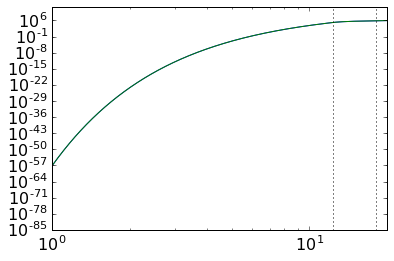

In [32]:
pl.figure()
pl.loglog(psilist,rholist)
pl.loglog(psilist,rho_of_psi(psilist))
#pl.loglog(psilist, alpha1*np.exp(-(14.2844298406921/psilist - 1.1)/(beta1)))
pl.axvline(psi_a, color='k', linestyle=":")
pl.axvline(psi_b, color='k', linestyle=":")
#pl.axvline(psi_min, color='k', linestyle=":")
pl.xlim(1, 20)
#pl.ylim(1e-20, 1e10)
pl.show()

In [33]:
drho = rho_of_psi.derivative(n=1)
d2rho = rho_of_psi.derivative(n=2)

In [34]:
c = 14.2844298406921
def d2rho_fixed_scalar(p):
    if (p < 0.1):
        return 0.0
    if (p >= 0.1):
        return d2rho(p)

d2rho_fixed = np.vectorize(d2rho_fixed_scalar)

In [35]:
d2rho(10)

array(14028.001659611826)

4.76513354407557


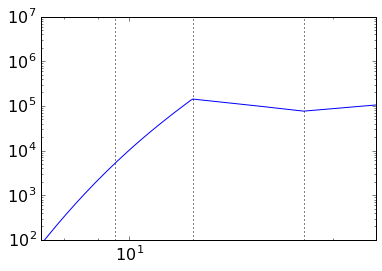

In [36]:
print psi(3.0)
pl.figure()
pl.loglog(psilist,drho(psilist))
#pl.semilogy(psilist,alpha1*np.exp(1.1/beta1)*np.exp(-c/(psilist*beta1))*c/(beta1*psilist**2))
pl.xlim(psi_b-5.0, psi_a+5.0)
pl.axvline(psi_a, color='k', linestyle=":")
pl.axvline(psi_b, color='k', linestyle=":")
pl.axvline(psi_min, color='k', linestyle=":")
pl.ylim(1e2, 1e7)
pl.show()

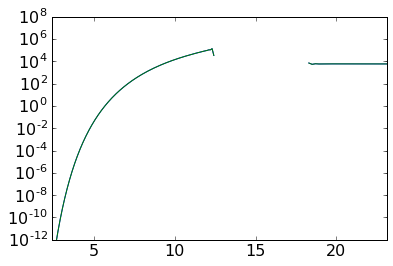

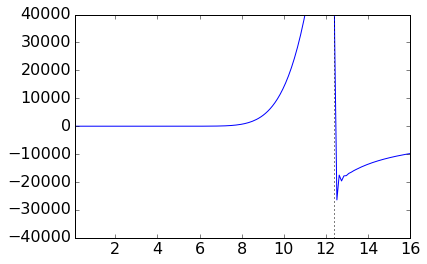

In [37]:
pl.figure()
pl.semilogy(psilist,d2rho_fixed(psilist))
pl.semilogy(psilist,d2rho(psilist))
#pl.plot(psilist,np.vectorize(d2rho_fixed)(psilist))
#pl.xlim(0, psi_tr)
pl.xlim(psi_b-10.0, psi_a +5.0)
pl.ylim(1e-12, 1e8)
#pl.axhline(240244.0,linestyle=':', color='k')
#pl.axhline(5148.09,linestyle=':', color='k')
pl.show()

pl.figure()
pl.plot(psilist,d2rho(psilist))
#pl.plot(psilist,d2rho_fixed(psilist)/np.sqrt(15.0 - psilist))
#pl.plot(psilist,np.vectorize(d2rho_fixed)(psilist))
pl.axvline(psi_a,linestyle=':', color='k')
pl.axvline(psi_b,linestyle=':', color='k')
pl.xlim(0.1, 16)
pl.ylim(-40000, 40000)
pl.show()



In [38]:
def calcf1(eps):
    #if (eps <= psi_min):
    #    return 0.0
    if (eps < 1e-10):
        return 0.0
    integ = lambda p: d2rho_fixed(p)/np.sqrt(eps - p)
    return quad(integ, 0, eps)[0]/(np.sqrt(8)*np.pi**2)

In [39]:
e_list = np.append(0.0,np.logspace(np.log10(1.0), np.log10(psi_max),1000))
#e_list = np.linspace(0.0, psi_max, 1000)

In [40]:
fvals = 0.0*e_list
for i in tqdm(range(len(e_list))):
    fvals[i] = calcf1(e_list[i])

print fvals

 23%|██▎       | 234/1001 [00:03<00:47, 16.20it/s] /opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
 34%|███▍      | 344/1001 [00:16<01:15,  8.76it/s]/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underesti

[  0.00000000e+00   7.47805690e-56   4.05452990e-55 ...,   2.38013198e+03
   2.38013201e+03   2.38018866e+03]


In [41]:
finterp = UnivariateSpline(e_list, fvals, k=1)
def f(eps):
    if (eps < 1):
        return 0.0
    return np.clip(finterp(eps),0*1e30,1e30)

f_vec = np.vectorize(f)

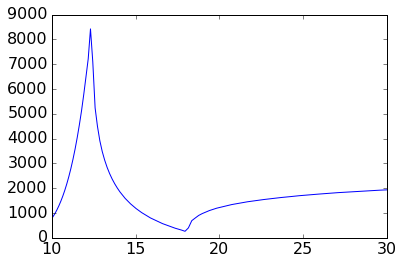

In [42]:
pl.figure()
pl.plot(e_list,f_vec(e_list))
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1e-10, 1000)
pl.xlim(10, 30)
pl.show()

**Re-checking the density:**

In [43]:
def vmax(x):
    return np.sqrt(2*float(psi(x)))

def dens(x):
    integ = lambda v: v**2*f(float(psi(x)) - 0.5*v**2)
    return 4*np.pi*quad(integ, 0, vmax(x))[0]

7.14769784245
13.0181814656611
14.610227782


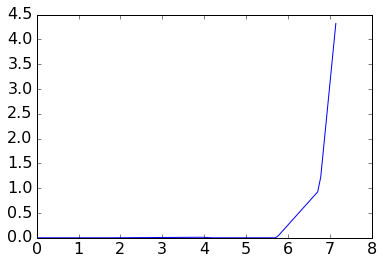

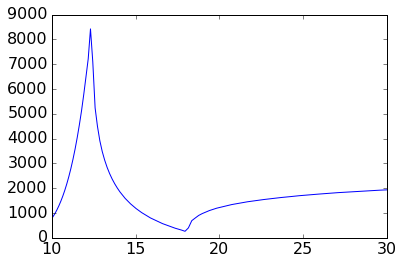

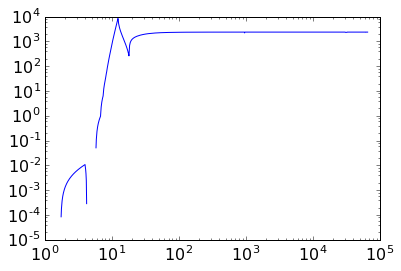

In [44]:
print float(psi(2.0))
print rho(2.0)
print dens(2.0)

elist2 = np.linspace(0, float(psi(2.0)),100)
pl.figure()
pl.plot(elist2,np.vectorize(f)(elist2))
pl.show()

pl.figure()
pl.plot(e_list,f_vec(e_list))
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1e-10, 1000)
pl.xlim(10, 30)
pl.show()

pl.figure()
pl.loglog(e_list,f_vec(e_list))
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1e-10, 1000)
pl.show()


In [61]:
xlist2 = np.logspace(-3, np.log10(2),100)
dens_list = 0.0*xlist2
for i in tqdm(range(len(xlist2))):
    dens_list[i] = dens(xlist2[i])

100%|██████████| 100/100 [01:07<00:00,  1.70it/s]


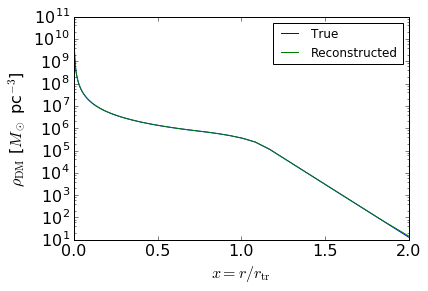

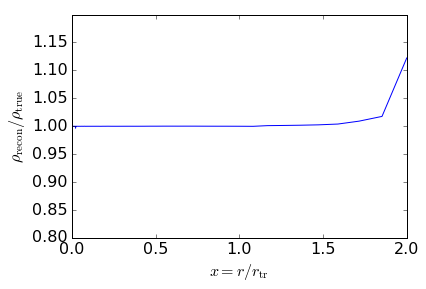

In [62]:
pl.figure()
pl.semilogy(xlist2, rho(xlist2), label="True")
pl.semilogy(xlist2, dens_list, label="Reconstructed")
pl.legend(loc='best',fontsize=12.0)
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")

pl.figure()
pl.plot(xlist2, dens_list/rho(xlist2))
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{recon}/\rho_\mathrm{true}$")
pl.ylim(0.8,1.2)
pl.show()

In [47]:
np.savetxt("distribution_trunc.dat",zip(e_list,np.clip(fvals,0,1e30)))

In [48]:
#Speed distribution f(v) at a given radius r
def f_scalar(x, v):
    if (v >= vmax(x)):
        return 0.0
    else:
        return 4.0*np.pi*(v**2)*f(float(psi(x)) - 0.5*v**2)/rho(x)

f_v = np.vectorize(f_scalar)

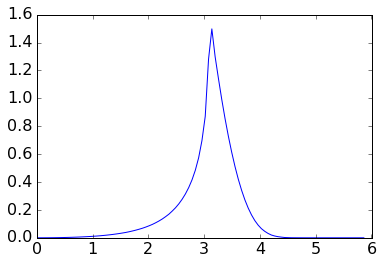

In [74]:
xpos = 0.8
vlist = np.linspace(0, vmax(xpos),100)
upper = 4*np.pi*vmax(xpos)**2*np.max(fvals[e_list < float(psi(xpos))])/rho(xpos)
#print upper
pl.figure()
pl.plot(vlist, f_v(xpos,vlist))
#pl.axhline(upper, linestyle=':', color='g')
#pl.axhline(15.0/vmax(xpos), linestyle=':', color='r')
pl.show()
